In [15]:
from importlib import reload
from PIL import Image
import os
import numpy as np
import torch
import pandas as pd
nn = torch.nn

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import seaborn as sns

import utils
import model.ngp as ngp
import main
import train
from torchvision.datasets import MNIST

In [6]:
cfg = utils.load_cfg('default256')

In [7]:
np.save(f'results/test', dict(R=R,N=N,F=F))

In [13]:
df = pd.read_csv('results/default.csv', index_col=0)

In [ ]:
sns.lineplot(data=df, x='size', y='psnr', hue='format');

In [12]:
np.load('results/test.npy', allow_pickle=True).item()

{'R': 8, 'N': 256, 'F': 6}

In [2]:
image_path = 'data/kodak/3.png'
img = np.array(Image.open(image_path)) / 255.
mnist = MNIST('data/mnist')

In [ ]:
# @title train baseline
reload(ngp);
n_iters=500
plot_every=100
R = 8
N = 2**10
F = 8
losses = []
model, optimizer = train.init_model(img, R=R, N=N, F=F, min_resolution=32, max_resolution=512, resolution_feature_scaler=0.2)
torch_img = torch.tensor(img).cuda()
for iter in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_every and (iter+1) % plot_every == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1,3, figsize=(10, 2.5), tight_layout=True)
        axes[0].imshow(img)
        axes[0].set_axis_off()
        axes[0].set_title('Ground Truth')
        render = model.render(to_numpy=True)
        ngp_psnr = utils.psnr(render, img)
        axes[1].imshow(render)
        axes[1].set_title(f'NGP ({ngp_psnr:.1f}dB)')
        axes[1].set_axis_off()
        axes[2].plot(losses)
        axes[2].set_ylim(0, 0.01)
        axes[2].set_title(f'Training loss')
        plt.show()

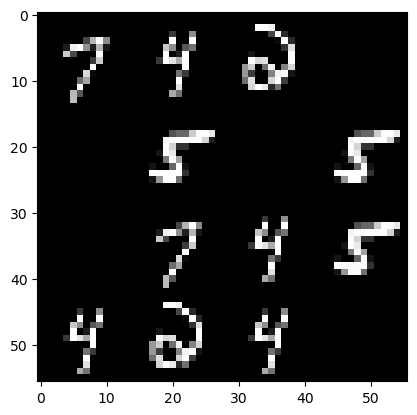

In [3]:
h,w = 14,14
H,W = h*4,w*4
np.random.seed(64)
n_textures = 5
toy_texture = np.zeros((H,W,3))
textures = np.stack([np.array(mnist[np.random.randint(len(mnist))][0]) for _ in range(n_textures)], axis=0)
textures = textures[:, ::2, ::2]
textures[0] = 0
textures = textures[..., None]
for x in range(0, H, h):
    for y in range(0, W, w):
        toy_texture[x:x+h, y:y+w] = textures[np.random.randint(n_textures)]
img = toy_texture / 255.
plt.imshow(img)

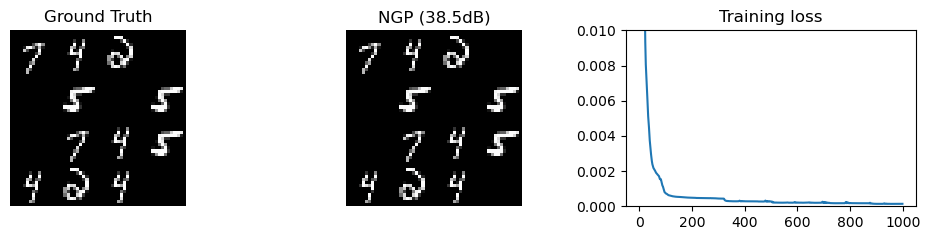

In [14]:
N = 2048
F = 4
n_iters = 1000
losses = []
plot_every = 100
model, optimizer = train.init_model(img, R=4, N=N, F=F, min_resolution=5, max_resolution=40)
torch_img = torch.tensor(img).cuda()
for iter in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_every and (iter+1) % plot_every == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1,3, figsize=(10, 2.5), tight_layout=True)
        axes[0].imshow(img)
        axes[0].set_axis_off()
        axes[0].set_title('Ground Truth')
        render = model.render(to_numpy=True)
        ngp_psnr = utils.psnr(render, img)
        axes[1].imshow(render)
        axes[1].set_title(f'NGP ({ngp_psnr:.1f}dB)')
        axes[1].set_axis_off()
        axes[2].plot(losses)
        axes[2].set_ylim(0, 0.01)
        axes[2].set_title(f'Training loss')
        plt.show()

In [50]:
reload(train);
model, optimizer = train.init_model(img, R=1, N=N, F=F, min_resolution=5, max_resolution=5)

tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 60. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.


In [6]:
coords = model.grid_coords()
for rix, res in enumerate(model.resolutions):
    x = coords * res
    x_ = torch.floor(x).long()
    w = x - x_
    x,y = x_[..., 0], x_[..., 1]
    break

In [13]:
x_.shape

torch.Size([3136, 2])

NameError: name 'np' is not defined

In [ ]:
idx = torch.bitwise_xor(x, 2654435761*y) % self.N

In [56]:
ngp_render = model.render(compress=True, to_numpy=True)
ngp_size = model.get_size()
ngp_psnr, ngp_ssim = utils.psnr(ngp_render, img), utils.ssim(ngp_render, img)
print(ngp_psnr, ngp_size, model.get_hash_size())

31.783907975341496 69.0 64.0


In [57]:
# @title quantize hash features
# model.hash_features = nn.Parameter(old_hash_features)
# model.hashmap = None

F = model.hash_features.shape[-1]
buckets_per_feat=8
quantized_feats, indices = model.quantize_table(buckets_per_feat)
old_hash_features = model.hash_features.clone()
model.update_hash_feats(quantized_feats, indices)

In [120]:
reload(ngp);
#model.hash_features = nn.Parameter(old_hash_features)
F = model.hash_features.shape[-1]
buckets_per_feat=round(2**(15/F))
quantized_feats, indices = model.quantize_table(buckets_per_feat)
old_hash_features = model.hash_features
model.update_hash_feats(quantized_feats, indices)

In [14]:
model.scatter_entries()

In [ ]:
# @title refine remapped hash features
n_iters=1000
plot_every=100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(.9,.99), eps=1e-15)
torch_img = torch.tensor(img).cuda()
for iter in range(n_iters):
    loss = ((model.render() - torch_img)**2).mean()
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if plot_every and (iter+1) % plot_every == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1,3, figsize=(10, 3), tight_layout=True)
        axes[0].imshow(img)
        axes[0].set_axis_off()
        axes[0].set_title('Ground Truth')
        render = model.render(to_numpy=True)
        ngp_psnr, ngp_ssim = utils.psnr(render, img), utils.ssim(render, img)
        axes[1].imshow(render)
        axes[1].set_title(f'NGP ({ngp_psnr:.1f}dB)')
        axes[1].set_axis_off()
        axes[2].plot(losses)
        axes[2].set_ylim(0, 0.01)
        axes[2].set_title(f'Training loss')
        plt.show()

In [ ]:
comp_render = model.render(compress=True, to_numpy=True)
cngp_size = model.get_size()
cngp_psnr, cngp_ssim = utils.psnr(comp_render, img), utils.ssim(comp_render, img)
print(cngp_psnr, cngp_size, model.get_hash_size(), model.get_hashmap_size())

27.352930934418698 36.75 13.75 16.0


In [53]:
# reload(utils)
jpg, jpg_size = utils.to_jpg(Image.open(image_path), quality=60)
jpg_psnr, jpg_ssim = utils.psnr(jpg, img), utils.ssim(jpg, img)

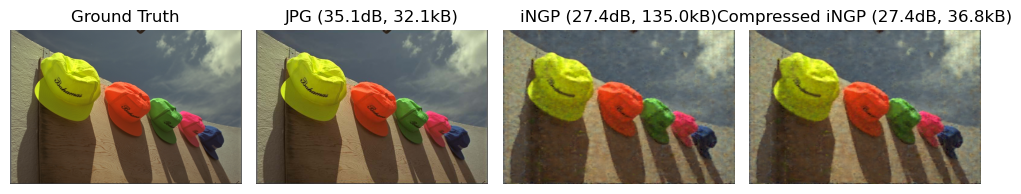

In [54]:
fig, axes = plt.subplots(1,4, figsize=(10, 3), tight_layout=True)
axes[0].imshow(img)
axes[0].set_title('Ground Truth')
axes[1].imshow(jpg)
axes[1].set_title(f'JPG ({jpg_psnr:.1f}dB, {jpg_size:.1f}kB)')
axes[2].imshow(render)
axes[2].set_title(f'iNGP ({ngp_psnr:.1f}dB, {ngp_size:.1f}kB)')
axes[3].imshow(comp_render)
axes[3].set_title(f'Compressed iNGP ({cngp_psnr:.1f}dB, {cngp_size:.1f}kB)')
for ax in axes.ravel():
    ax.set_axis_off()

In [123]:
counts = torch.zeros(model.hash_features.shape[0]).cuda()
means = torch.zeros(model.hash_features.shape[0]).cuda()
M2 = torch.zeros(model.hash_features.shape[0]).cuda()

pixelwise_diffs = ((model.render() - torch_img)**2).mean(axis=-1).flatten()

for iteration in range(1000):#range(pixelwise_diffs.shape[0]):
    if (iteration+1) % 100 == 0:
        print(iteration+1)
    pixel = np.random.randint(0, pixelwise_diffs.shape[0])
    optimizer.zero_grad()
    pixelwise_diffs[pixel].backward(retain_graph=True)
    grad = torch.linalg.norm(model.hash_features.grad, dim=1)
    nonzero = grad != 0
    newvalue = grad[nonzero]
    counts[nonzero] += 1
    delta = newvalue - means[nonzero]
    means[nonzero] += delta / counts[nonzero]
    delta2 = newvalue - means[nonzero]
    M2[nonzero] += delta * delta2

KeyboardInterrupt: 

In [124]:
variances = M2 / (counts - 1)
threshold = np.nanpercentile(variances.cpu().numpy(), 60)
high_var_mask = variances > threshold

In [126]:
buckets_per_feat = round(2**(12/F))
new_hash_features, new_indices = ngp.quantize_table(model.hash_features[high_var_mask], buckets_per_feat)
N_old = model.hash_features.shape[0]
N_new = new_hash_features.shape[0]
hash_feats = torch.cat((model.hash_features[~indices], new_hash_features))
new_hashmap = model.hashmap.clone()


In [128]:
high_var_mask

tensor([ True,  True, False,  ...,  True, False, False], device='cuda:0')

In [ ]:
for rix in range(model.hashmap.shape[0]):
    for idx in range(model.hashmap.shape[1]):
        
        model.hashmap[rix, idx] = hashmap[model.hashmap[rix, idx]]

In [ ]:
for i in range(N_old):
    if high_var_mask[i]:
        new_hashmap[new_indices[i]] = model.hashmap[i]
    else:
        new_hashmap = model.hashmap[]

In [101]:
new_hash_features.shape

torch.Size([42, 4])

In [ ]:
buckets_per_feat = round(2**(12/F))

In [ ]:
model.hash_features = 

In [ ]:
[(f.std().item()) for f in model.hash_features]

In [ ]:
# @title plot NGP features
H,W = model.shape
x = torch.stack(torch.meshgrid(torch.linspace(0,1,H), torch.linspace(0,1,W), indexing='ij'), -1).reshape(-1,2)
feats = model.bilerp_hash(x)
feats = feats.reshape(H,W,-1)
feats = feats.detach().numpy()
feats = (feats - feats.min()) / (feats.max() - feats.min())

In [ ]:
r,c = 3,3
fig, axes = plt.subplots(r,c, figsize=(5, 3.5), tight_layout=True)
for i in range(R):
    rgb = np.stack((feats[...,i*2], feats[...,i*2+1], feats[...,i*2]), -1)
    axes[i//c, i%c].imshow(rgb)
    axes[i//c, i%c].set_axis_off()

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(7, 3), tight_layout=True)
# axes[0].imshow(img)
# axes[0].set_title('Ground Truth')
# axes[1].imshow(jpg)
# axes[1].set_title(f'JPG (PSNR={jpg_psnr:.1f}, Size={jpg_size:.1f}kB)')
# for ax in axes.ravel():
#     ax.set_axis_off()

In [63]:
results = pd.read_csv('results.csv', index_col=0)

In [64]:
results.head()

,path,jpg_psnr,jpg_ssim,jpg_size,ngp_psnr,ngp_ssim,ngp_size
0,./data/12.png,35.205708,0.911433,34.061523,34.188784,0.861213,149.511719
1,./data/15.png,33.596209,0.900102,36.774414,32.578683,0.857874,149.511719
2,./data/20.png,34.138157,0.919594,32.333984,31.898736,0.886277,149.511719
3,./data/1.png,30.583400,0.902370,67.343750,26.061814,0.731666,149.511719
4,./data/6.png,31.931210,0.911806,53.834961,28.544023,0.799554,149.511719
